# Satellite Image Classification using CNN

## Topic

In this notebook I will work on classifying saltellite images of four kinds of body: water, desert, green area and cloudy. The dataset contains roughly 1500 instances on each type of aerial footage and will be seperated into training, validation and testing batches. I chose to work with a simple CNN (only a fex layers) after processing the images to be machine learning ready.
So let's get started !

## Objective

- Process image data
- Create a simple CNN and train it for a high accuracy

## Summary 

- Importing libraries
- The dataset
- Data processing
- Some Visualization
- Building the classifier
- Training and inference
- Trying out the model
- Conclusion

### Importing libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
from os import listdir
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
from glob import glob
import shutil
import cv2

### The Dataset

In [2]:
water = glob(r'C:\Users\imane\Downloads\archive (17)\train\water\*')
print(len(water))

1500


In [3]:
green = glob(r'C:\Users\imane\Downloads\archive (17)\train\green_area\*')
print(len(green))

1500


In [4]:
desert = glob(r'C:\Users\imane\Downloads\archive (17)\train\desert\*')
print(len(desert))

1131


In [5]:
cloudy = glob(r'C:\Users\imane\Downloads\archive (17)\train\cloudy\*')
print(len(cloudy))

1500


In [6]:
water_t = water[:1440]
water_v = water[1440:]
for file in water_v:
    new_path = r"C:\Users\imane\Downloads\archive (17)\test\water" 
    shutil.move(file, new_path)

In [7]:
green_t = green[:1440]
green_v = green[1440:]
for file in green_v:
    new_path = r"C:\Users\imane\Downloads\archive (17)\test\green_area" 
    shutil.move(file, new_path)

In [8]:
desert_t = desert[:1071]
desert_v = desert[1071:]
for file in desert_v:
    new_path = r"C:\Users\imane\Downloads\archive (17)\test\desert" 
    shutil.move(file, new_path)

In [9]:
cloudy_t = cloudy[:1440]
cloudy_v = cloudy[1440:]
for file in cloudy_v:
    new_path = r"C:\Users\imane\Downloads\archive (17)\test\cloudy" 
    shutil.move(file, new_path)

The dataset contains files of four kinds of azrial footage, it only contains one file for all and doesn't seperate the traing and testing data. So what I did was keep 60 pictures per class for the testing and transfered it to the test file that I have created.

In [10]:
im = cv2.imread(water[58])
print(im.shape)

(64, 64, 3)


In [11]:
im = cv2.imread(green[58])
print(im.shape)

(64, 64, 3)


In [12]:
im = cv2.imread(desert[58])
print(im.shape)

(256, 256, 3)


In [13]:
im = cv2.imread(cloudy[58])
print(im.shape)

(256, 256, 3)


Apparently the images have different sizes which means I'll have to resize later.

In [16]:
files = glob(r'C:\Users\imane\Downloads\archive (17)\train\*')
files

['C:\\Users\\imane\\Downloads\\archive (17)\\train\\cloudy',
 'C:\\Users\\imane\\Downloads\\archive (17)\\train\\desert',
 'C:\\Users\\imane\\Downloads\\archive (17)\\train\\green_area',
 'C:\\Users\\imane\\Downloads\\archive (17)\\train\\water']

In [17]:
classes = ["cloudy", "desert", "green area", "water"]
classes

['cloudy', 'desert', 'green area', 'water']

Here I got the names of the classes in the order they are downloaded in the file.

### Data processing

In [18]:
data_dir = r'C:\Users\imane\Downloads\archive (17)'

train_transforms = transforms.Compose([transforms.Resize(64),
                                       transforms.CenterCrop(64),
                                       transforms.RandomRotation(60),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.CenterCrop(64),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [19]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

In [20]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [21]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [22]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size)

In [23]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() 
images.shape

(20, 3, 64, 64)

The next thing I did was define the transforms that I want my data to go through. I started with resizing, center croping, then random rotation and flip then finaly converting to tensors and normalizing. Then I created a subset of the training data for validation and determined the data loaders. The final size of my batch is 20 (the size), 3 (color channels) and 64*64 height and width.

### Some visualization

In [24]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))

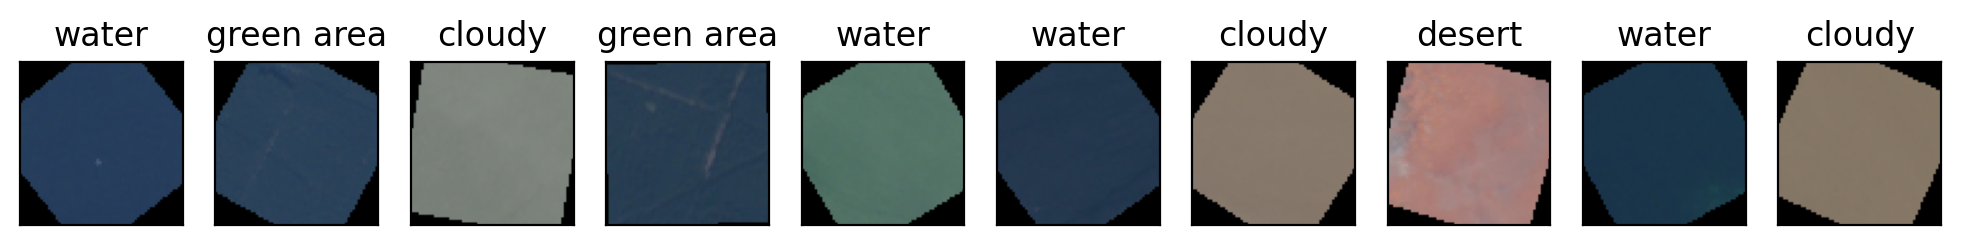

In [25]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

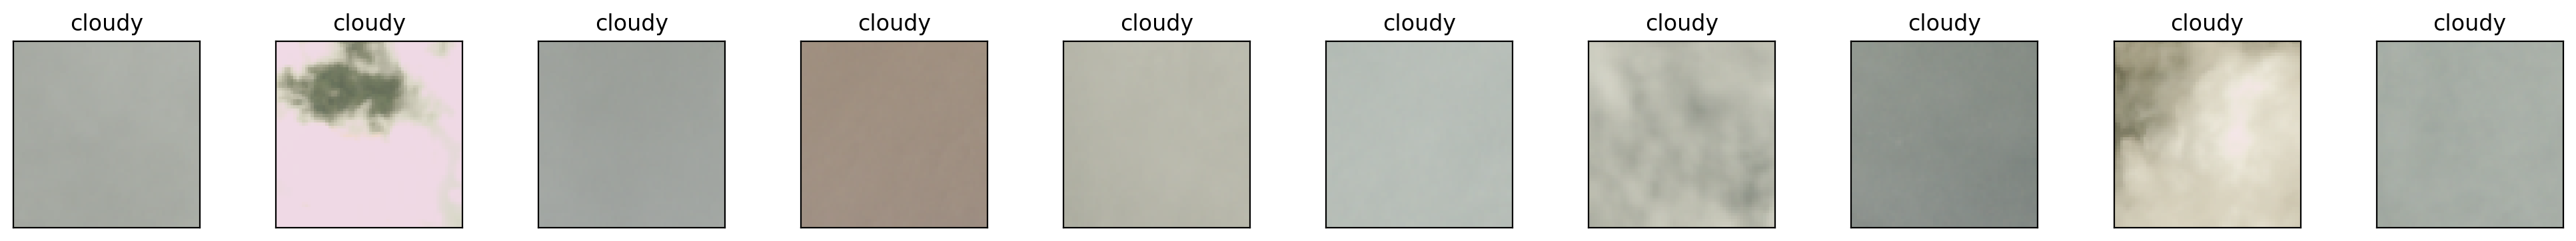

In [26]:
images, labels = next(iter(test_loader))
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Here I simply created the function to undo the transformations and plot the original images accompagnied by their labels..

### Building the classifier

In [31]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding =1)
        
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(8*8*48, 119)
        self.fc2 = nn.Linear(119, 4)
        
        self.dropout = nn.Dropout(p= 0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool(F.relu(self.batchn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

In [32]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.0005)

In [33]:
print(model)

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=119, bias=True)
  (fc2): Linear(in_features=119, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In this part I built a small convolutional network composed of 3 convolutional layers each adding 16 additional layers than the one before it, then after the flattening I used only 2 fully connected layers with a dropout probability of .25. The pooling I used was 2*2 and stride of 2 after each convolution, I also used padding with 1 pixel.

### Training and inference

In [34]:
epochs = 50

valid_loss_min = np.Inf
train_accuracy, val_accuracy = [],[]

for epoch in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item()*images.size(0)
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item()*images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_accuracy.append(t_acc/len(train_loader.sampler))
    val_accuracy.append(v_acc/len(valid_loader.sampler))
    
    print("Epoch ", epoch+1, "train loss ", train_loss, "validation loss ", valid_loss)
    
    if valid_loss <= valid_loss_min:
        print("validation loss decreased", valid_loss_min, "---->", valid_loss)
        print("Saving the model")
        torch.save(model.state_dict(), "model_cnn.pt")
        valid_loss_min = valid_loss

Epoch  1 train loss  1.0927882560604607 validation loss  0.8578599700237691
validation loss decreased inf ----> 0.8578599700237691
Saving the model
Epoch  2 train loss  0.769387604823777 validation loss  0.6346277417632334
validation loss decreased 0.8578599700237691 ----> 0.6346277417632334
Saving the model
Epoch  3 train loss  0.6290176444890575 validation loss  0.527801268397103
validation loss decreased 0.6346277417632334 ----> 0.527801268397103
Saving the model
Epoch  4 train loss  0.5570531951947193 validation loss  0.4502079060546542
validation loss decreased 0.527801268397103 ----> 0.4502079060546542
Saving the model
Epoch  5 train loss  0.4875201788546728 validation loss  0.39957014859717943
validation loss decreased 0.4502079060546542 ----> 0.39957014859717943
Saving the model
Epoch  6 train loss  0.4477641909948336 validation loss  0.36217089359525845
validation loss decreased 0.39957014859717943 ----> 0.36217089359525845
Saving the model
Epoch  7 train loss  0.4133290966798

The training phase went smoothly and quickly with the model easily converging and its error dropping from .85 at epoch 1 to .12 at epoch 49. I saved the model with the lowest validation error.

In [35]:
model.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

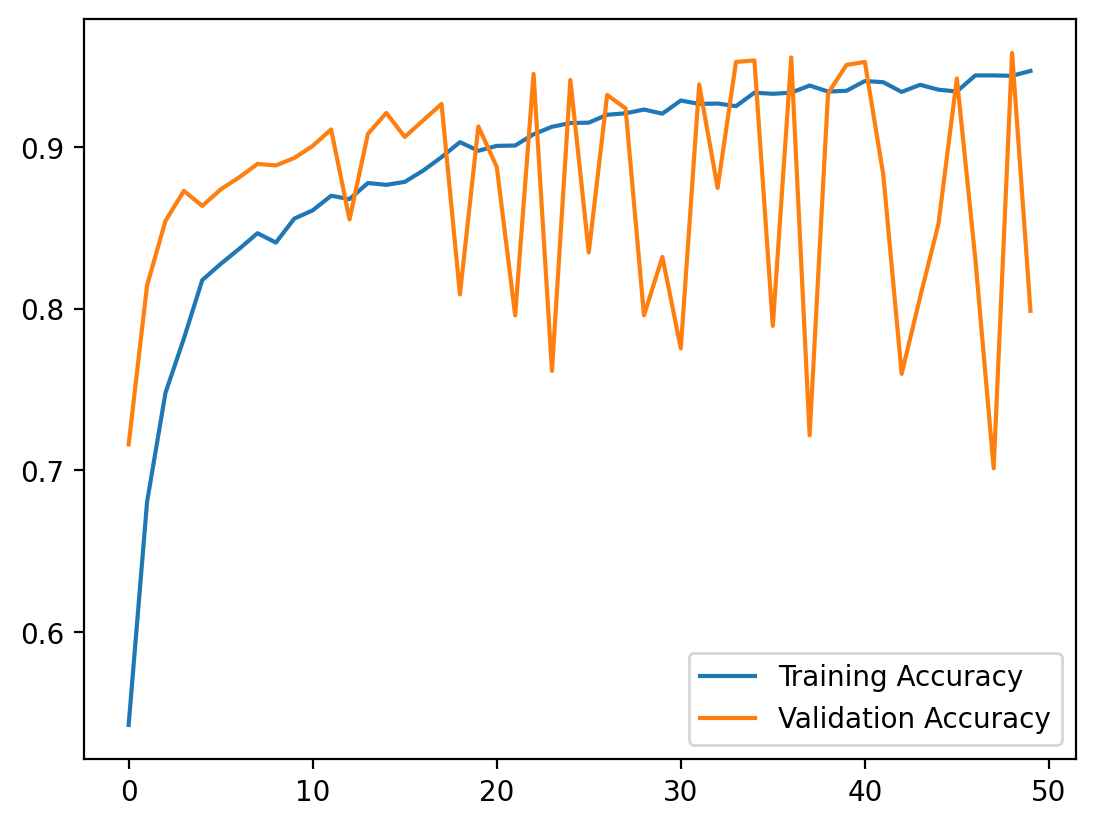

In [36]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

Plotting the training againt validation accuracy shows that the model doesn't overfit.

In [37]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    for i in range(len(target)):

        label = target.data[i]
    
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.097372

Test Accuracy of cloudy: 100% (60/60)
Test Accuracy of desert: 100% (60/60)
Test Accuracy of green area: 96% (58/60)
Test Accuracy of water: 98% (59/60)

Test Accuracy (Overall): 98% (237/240)


So here I tested my model and kepot track of its overall accuracy (98%) and its accuracy per catergory. The results are amazing and the model was able to get 100% on 2 categories.

### Trying out the model

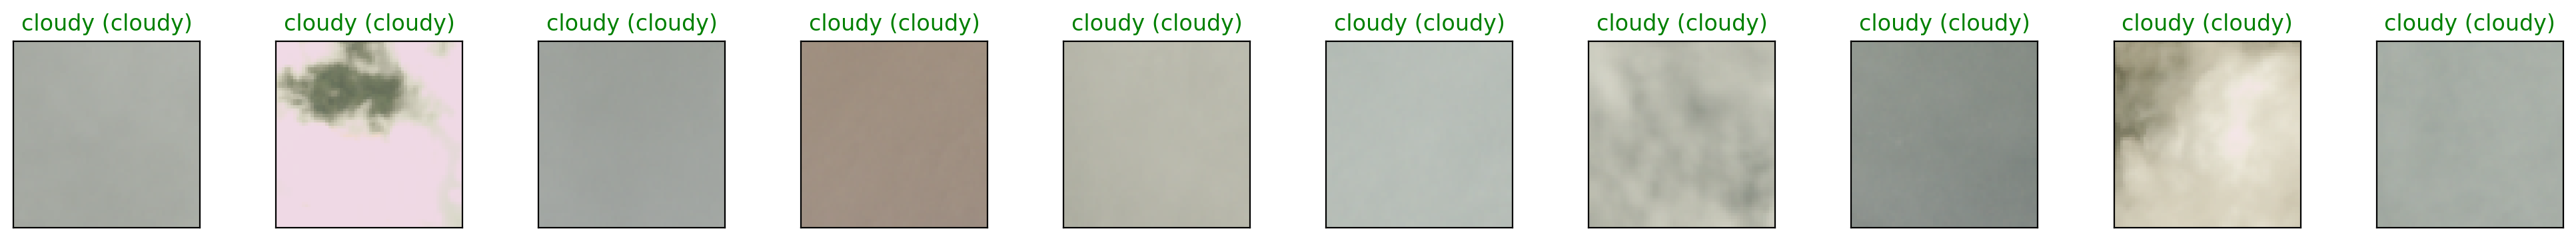

In [38]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Conclusion

In this notebook I used a simple data set and a simple network to classify its categories. I started out with images of four kinds of aerial footage (water, green body, clouds and desert) that I processed to be finally be normalized tensors that I then fed to my 5 layer convolutional network (3 conv layers and 2 fully connected layers). The results were nearly perfect, my model obtained a 98% overall accuracy and 100% accuracy on two of the categories. I can say that I'm pretty pleased with the results obtained through this project.